In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Eigenfaces

In dieser Übung betrachten wir das Problem der Gesichtserklärung mit Eigenfaces.



## Laden Sie die lfw_people-Daten aus sklearn 

- from sklearn.datasets import fetch_lfw_people
- Nutzen sie Personen, bei denen mindestens 100 Bilder pro Person vorhanden sind
- Splitten Sie die Daten in train & test




In [2]:
from sklearn.datasets import fetch_lfw_people

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
X = lfw_people.data
y= lfw_people.target
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25, random_state=42)

In [4]:
scaler=StandardScaler()
Xtrain=scaler.fit_transform(Xtrain)
Xtest=scaler.fit_transform(Xtest)

- Berechnen sie die ersten 100 PCA-Komponenten
- Plotten sie das mittlere Gesicht, Sowie die Eigenfaces

In [5]:
n_components = 100
n_samples, h, w = lfw_people.images.shape
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True).fit(Xtrain)

eigenfaces=pca.components_.reshape((n_components, h, w))
Xtrain_pca = pca.transform(Xtrain)
Xtest_pca=pca.transform(Xtest)


In [6]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


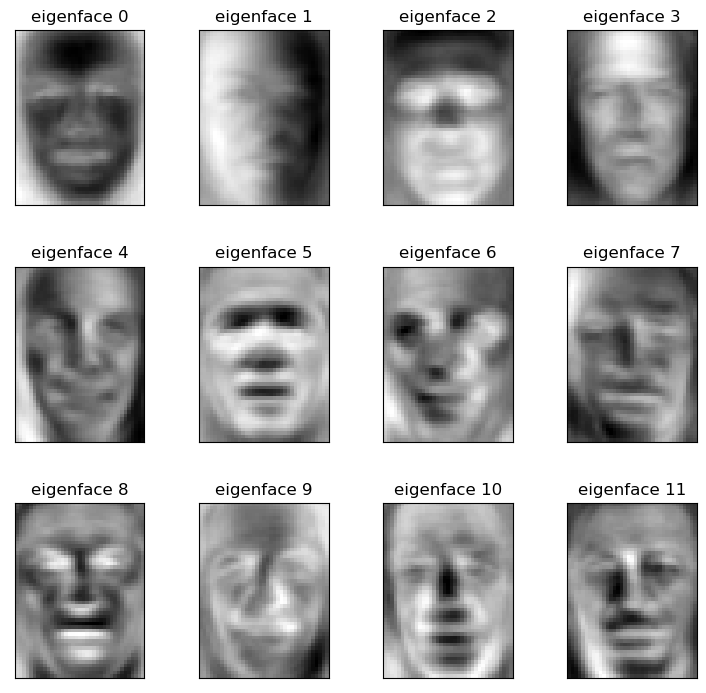

In [7]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces,eigenface_titles, h, w)

Erstellen sie eine SupportvektorMaschine zur Gesichtserkennung

In [8]:
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    "C": loguniform(1e3, 1e5),
    "gamma": loguniform(1e-4, 1e-1),
}
clf = RandomizedSearchCV(
    SVC(kernel="rbf", class_weight="balanced"), param_grid, n_iter=10
)
clf = clf.fit(Xtrain_pca, ytrain)
ypred = clf.predict(Xtest_pca)

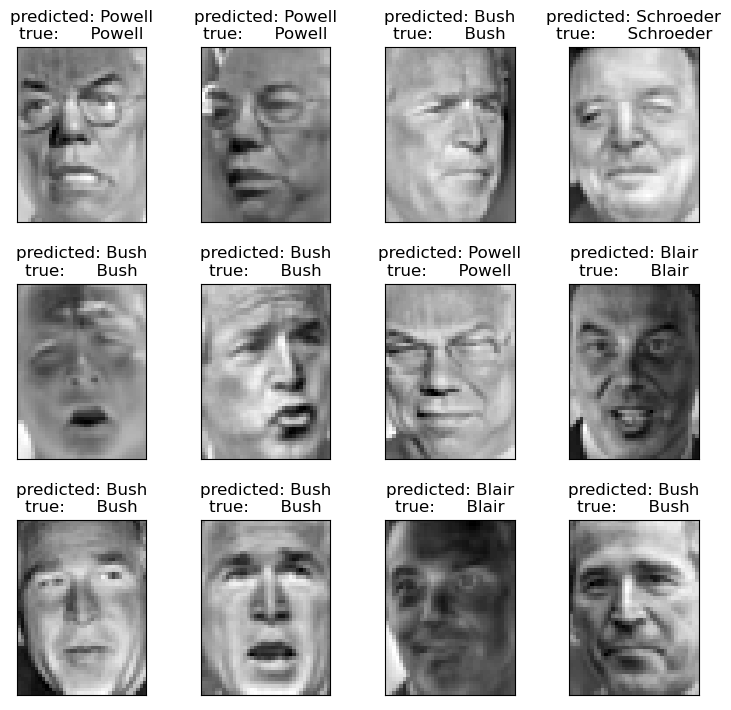

In [9]:
target_names = lfw_people.target_names
def title(y_pred, ytest, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[ytest[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)


prediction_titles = [
    title(ypred, ytest, target_names, i) for i in range(ypred.shape[0])
]

plot_gallery(Xtest, prediction_titles, h, w)

Erstellen sie ein Neuronales Netz zur Gesichtserkennung mit Eigenfaces

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical

In [11]:
model = Sequential()
model.add(Dense(64, input_dim=100, activation='sigmoid'))
model.add(Dense(5, activation='softmax'))

model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

model.fit(Xtrain_pca, to_categorical(ytrain), epochs=100)

Epoch 1/100
27/27 [==============================] - 0s 1ms/step - loss: 1.5895 - accuracy: 0.2912
Epoch 2/100
27/27 [==============================] - 0s 970us/step - loss: 1.4313 - accuracy: 0.4585
Epoch 3/100
27/27 [==============================] - 0s 922us/step - loss: 1.4034 - accuracy: 0.4690
Epoch 4/100
27/27 [==============================] - 0s 955us/step - loss: 1.3883 - accuracy: 0.4690
Epoch 5/100
27/27 [==============================] - 0s 1ms/step - loss: 1.3765 - accuracy: 0.4702
Epoch 6/100
27/27 [==============================] - 0s 902us/step - loss: 1.3636 - accuracy: 0.4725
Epoch 7/100
27/27 [==============================] - 0s 951us/step - loss: 1.3523 - accuracy: 0.4725
Epoch 8/100
27/27 [==============================] - 0s 929us/step - loss: 1.3397 - accuracy: 0.4737
Epoch 9/100
27/27 [==============================] - 0s 926us/step - loss: 1.3281 - accuracy: 0.4725
Epoch 10/100
27/27 [==============================] - 0s 865us/step - loss: 1.3161 - accuracy: 

In [12]:
res=model.predict(Xtest_pca)


9/9 [==============================] - 0s 751us/step


In [13]:
print(res)

[[0.37769955 0.04137609 0.50093085 0.0214619  0.05853165]
 [0.91239274 0.01471876 0.02341569 0.03739629 0.01207647]
 [0.00777091 0.05873487 0.9066723  0.01172497 0.01509699]
 ...
 [0.00358384 0.00691099 0.9821399  0.00366783 0.00369748]
 [0.01959505 0.27939835 0.6291677  0.02935318 0.04248575]
 [0.05918212 0.03300778 0.3728899  0.08113129 0.45378888]]


In [19]:
correct = 0
total = 0
for i in range(len(ytest)):
    act_label = np.argmax(to_categorical(ytest[i]))# act_label = 1 (index)
    pred_label = np.argmax(res[i]) # pred_label = 1 (index)
    if(act_label == pred_label):
        correct += 1
    total += 1
accuracy = (correct/total)
print(accuracy)

0.8210526315789474
